In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Load data 
train = pd.read_csv("../train_data.csv") # Training data
test = pd.read_csv("../test_data.csv") # Test data 

In [2]:
# Available features
list(train)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

<AxesSubplot:>

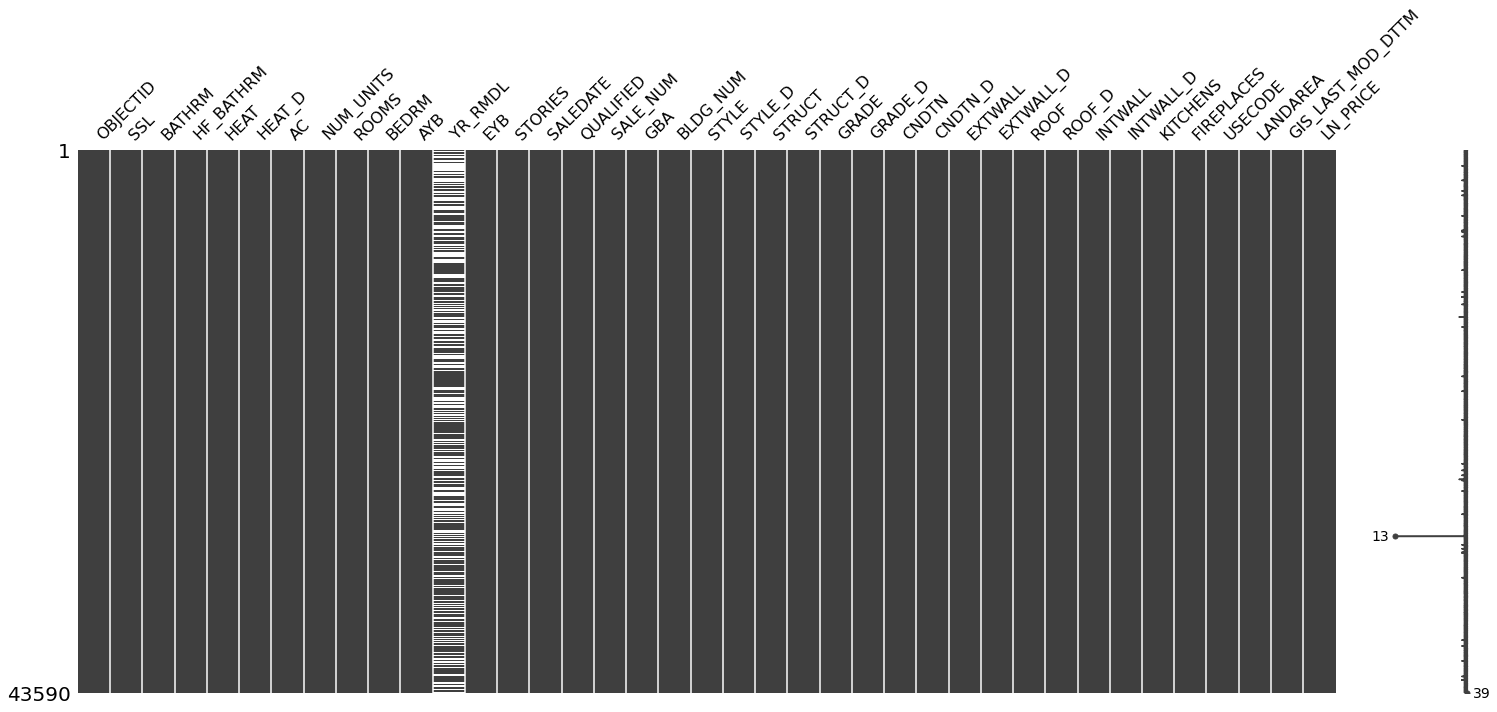

In [3]:
miss.matrix(train)

In [4]:
# Clean training data 
train = train.dropna() # Drop missing values 
train = train.replace([np.inf, -np.inf, -0], 0) # Replace float inf with zeroes 
train = train[~train.LN_PRICE.isna()]

train_y = train['LN_PRICE'] # OUTCOME
train_X = train[['CNDTN', 'BATHRM','BEDRM','LANDAREA','ROOMS']] # PREDICTORS
train['LANDAREA'] = np.log(train['LANDAREA']) # Log land area
train_X.shape # Dimensions of predictors 



(24998, 5)

In [5]:
# Clean test data 
test = test.dropna()
test = test.replace([np.inf, -np.inf, -0], 0)
test = test[~test.LN_PRICE.isna()]

test_y = test['LN_PRICE'] 
test_X = test[['CNDTN', 'BATHRM','BEDRM','LANDAREA','ROOMS']] 
test['LANDAREA'] = np.log(test['LANDAREA'])
test_X.shape

(8328, 5)

In [6]:
# Scale train data 
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)
train_X = pd.DataFrame(train_X,columns=col_names)

# Scale test data 
scaler = pp.MinMaxScaler()
col_names = list(test_X)
test_X = scaler.fit_transform(test_X)
test_X = pd.DataFrame(test_X,columns=col_names)


train_X

,CNDTN,BATHRM,BEDRM,LANDAREA,ROOMS
0,0.833333,0.272727,0.074074,0.012962,0.300000
1,0.500000,0.181818,0.074074,0.049136,0.300000
2,0.500000,0.181818,0.074074,0.012082,0.366667
3,0.666667,0.272727,0.074074,0.014022,0.233333
4,0.666667,0.272727,0.055556,0.007348,0.233333
...,...,...,...,...,...
24993,0.500000,0.090909,0.037037,0.002210,0.166667
24994,0.666667,0.181818,0.055556,0.008138,0.233333
24995,0.666667,0.181818,0.074074,0.007560,0.300000
24996,0.666667,0.272727,0.055556,0.004252,0.200000


In [7]:
use_metrics = ["neg_mean_squared_error"]
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)



In [8]:


# Output is a dictionary 
lm_scores

# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores



,Model,MSE
0,lm,0.404023
1,lm,0.436837
2,lm,0.480563
3,lm,0.445571
4,lm,0.429469
5,knn,0.444189
6,knn,0.463744
7,knn,0.497778
8,knn,0.487493
9,knn,0.464502


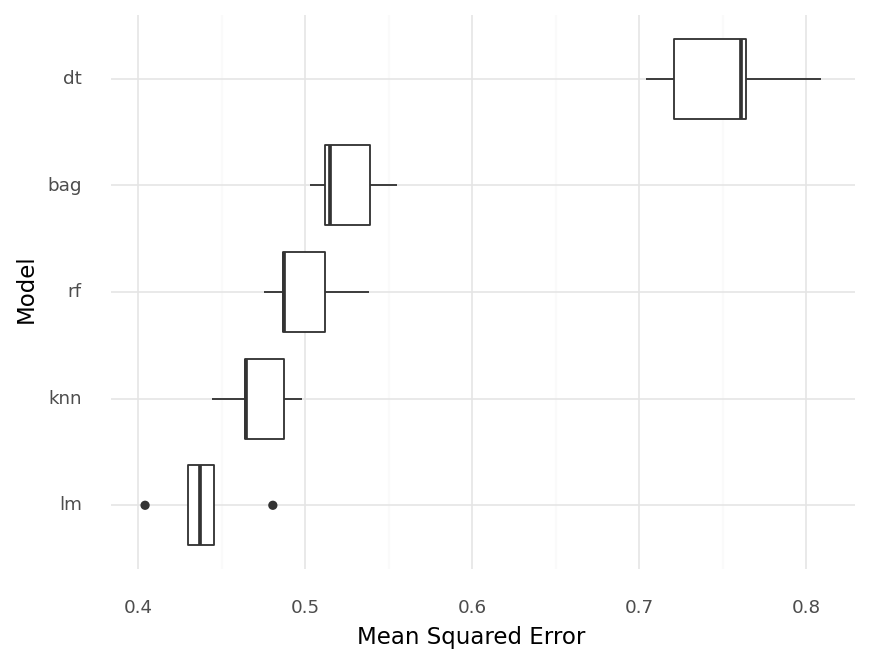

<ggplot: (142541560974)>

In [9]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

In [10]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['CNDTN', 'BATHRM','BEDRM','LANDAREA','ROOMS'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[25,50,75,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[4,5,6,7,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[2,3,4],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['CNDTN',
                                                                          'BATHRM',
                                                                          'BEDRM',
                                                                          'LANDAREA',
                                                                          'ROOMS'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=50)],
                          'model__n_neighbors': [25, 50, 75, 100]},
    

In [11]:
search.best_score_ 

-0.4092959089715462

In [12]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=50), 'model__n_neighbors': 50}

In [13]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

m.mean_squared_error(test_y,pred_y)

0.42964505794300806

In [14]:
m.r2_score(test_y,pred_y)

0.2910206752099853

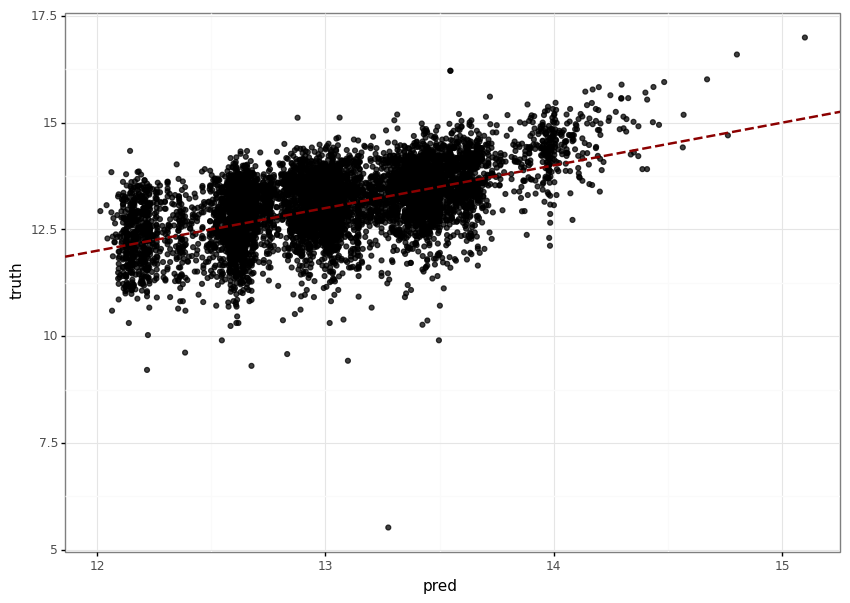

<ggplot: (142546495226)>

In [15]:


(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

